In [1]:
import sys
import pandas as pd
import numpy as np
import os
from scipy.ndimage import rotate
import scipy.ndimage
from joblib import Parallel, delayed
import multiprocessing
import itertools
import pydicom
import SimpleITK as sitk
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split

#Code from existing github repo provided by UC Irvine dataset
sys.path.append(os.getcwd())
import utils
import equalizer
from utils import cutCube
from equalizer import histEq


In [2]:
processed_training_data = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/lungdeepfake/combined_tampered_scans_dataset_train.npy"
processed_training_labels = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/lungdeepfake/combined_tampered_scans_dataset_train_labels.npy"

processed_val_data = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/lungdeepfake/combined_tampered_scans_dataset_val.npy"
processed_val_labels = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/lungdeepfake/combined_tampered_scans_dataset_val_labels.npy"

processed_test_data = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/lungdeepfake/combined_tampered_scans_dataset_test.npy"
processed_test_labels = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/lungdeepfake/combined_tampered_scans_dataset_test_labels.npy"


In [3]:
from sklearn.preprocessing import LabelEncoder

# Loading Training data
loaded_train_data = np.load(processed_training_data)
loaded_train_labels = np.load(processed_training_labels)

# Loading Validation data
loaded_val_data = np.load(processed_val_data)
loaded_val_labels = np.load(processed_val_labels)

# Loading Test data
loaded_test_data = np.load(processed_test_data)
loaded_test_labels = np.load(processed_test_labels)

le = LabelEncoder()
transformed_train_labels = le.fit_transform(loaded_train_labels)
transformed_val_labels = le.transform(loaded_val_labels)
transformed_test_labels = le.transform(loaded_test_labels)

print(f'Shape of training data: {loaded_train_data.shape}, Shape of training labels: {transformed_train_labels.shape}')
print(f'Shape of validation data: {loaded_val_data.shape}, Shape of training labels: {transformed_val_labels.shape}')
print(f'Shape of training data: {loaded_test_data.shape}, Shape of training labels: {transformed_test_labels.shape}')


Shape of training data: (970, 32, 32, 32), Shape of training labels: (970,)
Shape of validation data: (33, 32, 32, 32), Shape of training labels: (33,)
Shape of training data: (33, 32, 32, 32), Shape of training labels: (33,)


In [4]:
train_middle_slices = loaded_train_data[:, 16, :, :]
val_middle_slices = loaded_val_data[:, 16, :, :]
test_middle_slices = loaded_test_data[:, 16, :, :]

print(f'Shape of middle slices: {train_middle_slices.shape}')
print(f'Shape of middle slices: {val_middle_slices.shape}')
print(f'Shape of middle slices: {test_middle_slices.shape}')


Shape of middle slices: (970, 32, 32)
Shape of middle slices: (33, 32, 32)
Shape of middle slices: (33, 32, 32)


In [5]:
train_images = train_middle_slices[:,:,:,np.newaxis]
val_images = val_middle_slices[:,:,:,np.newaxis]
test_images = test_middle_slices[:,:,:,np.newaxis]

print(f'Shape of training slices: {train_images.shape}')
print(f'Shape of validation slices: {val_images.shape}')
print(f'Shape of test slices: {test_images.shape}')


Shape of training slices: (970, 32, 32, 1)
Shape of validation slices: (33, 32, 32, 1)
Shape of test slices: (33, 32, 32, 1)


In [6]:
import tensorflow as tf
np.random.seed(1234)
tf.random.set_seed(1234)

2025-08-07 15:34:17.012909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(transformed_train_labels),
                                     y=transformed_train_labels)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 0.5511363636363636, 1: 1.0104166666666667, 2: 2.6944444444444446, 3: 1.2125}


In [8]:
print(train_images.shape)
raw_features_shape = train_images[:,:,:,0].shape[1] * train_images.shape[2] * train_images.shape[3]
print(f'Total number of features used for Decision Forests: {raw_features_shape}')

(970, 32, 32, 1)
Total number of features used for Decision Forests: 1024


In [9]:
X_train_rf = train_images.reshape(train_images.shape[0],raw_features_shape)
X_val_rf = val_images.reshape(val_images.shape[0],raw_features_shape)
X_test_rf = test_images.reshape(test_images.shape[0],raw_features_shape)

print(f'Shape of training, val, test images: {X_train_rf.shape}, {X_val_rf.shape}, {X_test_rf.shape}')

Shape of training, val, test images: (970, 1024), (33, 1024), (33, 1024)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
random_forest_model = RandomForestClassifier(n_estimators=50,max_features='sqrt',max_depth=8,class_weight='balanced',random_state=42)
rf_history = random_forest_model.fit(X_train_rf, transformed_train_labels)

rf_train_pred = rf_history.predict(X_train_rf)
print(f'Train accuracy: {accuracy_score(transformed_train_labels, rf_train_pred)}')

rf_val_pred = rf_history.predict(X_val_rf)
print(f'Validation accuracy: {accuracy_score(transformed_val_labels, rf_val_pred)}')

rf_test_pred = rf_history.predict(X_test_rf)
print(f'Test accuracy: {accuracy_score(transformed_test_labels, rf_test_pred)}')

Train accuracy: 1.0
Validation accuracy: 0.9393939393939394
Test accuracy: 0.8787878787878788


In [11]:
from sklearn.metrics import classification_report

print(classification_report(transformed_test_labels, rf_test_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        14
           1       0.89      1.00      0.94         8
           2       0.00      0.00      0.00         3
           3       1.00      0.88      0.93         8

    accuracy                           0.88        33
   macro avg       0.68      0.72      0.69        33
weighted avg       0.81      0.88      0.84        33



/Users/ugorur/Desktop/PyCharm_Projects/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ugorur/Desktop/PyCharm_Projects/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ugorur/Desktop/PyCharm_Projects/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

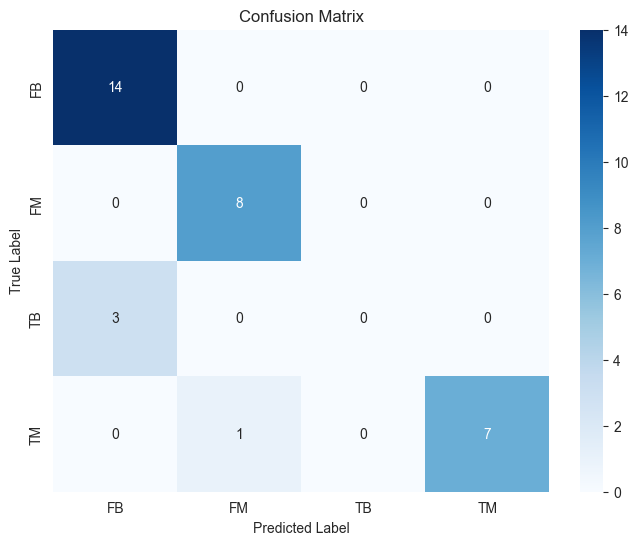

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(transformed_test_labels, rf_test_pred)

# Get class names from the label encoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()